In [31]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [32]:
sales_data = pd.read_csv('dataset/Project Dataset/sales_data.csv')
amount_data = pd.read_csv('dataset/Project Dataset/amount_data.csv')

In [33]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'], dayfirst = True)
sales_data = sales_data.sort_values(by = 'Date')
sales_data = sales_data.reset_index().drop(columns=['index'])
sales_data

,Date,Model,Quantity
0,2022-04-01,18 F AC,0.0
1,2022-04-01,3X7NEXX,0.0
2,2022-04-01,2T5GDEL,0.0
3,2022-04-01,2T5RRLX-GX,0.0
4,2022-04-01,2T5RRLX-XX,0.0
...,...,...,...
93598,2024-04-30,40 inch LED,0.0
93599,2024-04-30,32 inch LED,0.0
93600,2024-04-30,Multiplug,0.0
93601,2024-04-30,1D4GDEH,1.0


In [34]:
amount_data['Date'] = pd.to_datetime(amount_data['Date'], dayfirst = True)
amount_data = amount_data.sort_values(by = 'Date')
amount_data = amount_data.reset_index().drop(columns=['index'])
amount_data

,Date,Amount
0,2022-04-01,0
1,2022-04-02,239400
2,2022-04-03,274140
3,2022-04-04,177000
4,2022-04-05,106000
...,...,...
756,2024-04-26,0
757,2024-04-27,582650
758,2024-04-28,367700
759,2024-04-29,451000


In [35]:
sales_data_matrix = sales_data.pivot_table(index = 'Date', columns = 'Model', values = 'Quantity', aggfunc = 'sum', fill_value = 0)
sales_data_matrix

Model,12 C AC,12 inch Fan,14 inch Fan,17 inch Fan,18 A AC,18 C AC,18 F AC,1B3GDEL,1B6GDEH,1B6GDEL,...,Room Heater,Ruti Tawa,Speaker,Stabilizer,Stand Fan,Tornedo Fan,Wall Move,Washing Machine,Water Filter,Weight Scale
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-03,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2022-04-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-27,0.0,0.0,3.0,11.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
2024-04-28,1.0,0.0,2.0,20.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Dictionary to store the predictions
predictions = {}
mae_scores = []
mse_scores = []
rmse_scores = []

models = []

# Iterating over each products
for product in sales_data_matrix.columns:
    # Filtering data for the specific product
    df_model = sales_data[sales_data['Model'] == product][['Date', 'Quantity']].rename(columns={'Date': 'ds', 'Quantity': 'y'})
    
    train_data = df_model.iloc[:-30]
    test_data = df_model.iloc[-30:]

    # Initializing Prophet model
    prophet_model = Prophet()
    
    # Fiting the model
    prophet_model.fit(train_data)
    
    # Predict future quantities
    forecast = prophet_model.predict(test_data)
    
    # Store the predictions
    predictions[product] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    mae = mean_absolute_error(test_data['y'], forecast['yhat'])
    mae_scores.append(mae)

    mse = mean_squared_error(test_data['y'], forecast['yhat'])
    mse_scores.append(mse)

    rmse = root_mean_squared_error(test_data['y'], forecast['yhat'])
    rmse_scores.append(rmse)

    print(product)
    print(mae)
    print(mse)
    print(rmse)


print("Average Mean Absolute Error " , np.mean(mae_scores))
print("Average Mean Squared Error " , np.mean(mse_scores))
print("Average Root Mean Square Error " , np.mean(rmse_scores))

20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing
20:24:50 - cmdstanpy - INFO - Chain [1] start processing


12 C AC
0.17018797616655043
0.1796398106429972
0.4238393689158632


20:24:50 - cmdstanpy - INFO - Chain [1] done processing
20:24:50 - cmdstanpy - INFO - Chain [1] start processing


12 inch Fan
0.5309649079587175
0.35486844610228374
0.5957083565825511


20:24:51 - cmdstanpy - INFO - Chain [1] done processing
20:24:51 - cmdstanpy - INFO - Chain [1] start processing


14 inch Fan
1.9473330584038544
6.485592988449932
2.546682742009678


20:24:51 - cmdstanpy - INFO - Chain [1] done processing


17 inch Fan
6.165829708134198
97.86576868763937
9.892712908380561


20:24:51 - cmdstanpy - INFO - Chain [1] start processing
20:24:51 - cmdstanpy - INFO - Chain [1] done processing
20:24:52 - cmdstanpy - INFO - Chain [1] start processing


18 A AC
0.13153873350706302
0.03891356646384422
0.19726521858615678


20:24:52 - cmdstanpy - INFO - Chain [1] done processing
20:24:52 - cmdstanpy - INFO - Chain [1] start processing


18 C AC
0.45802570501827405
0.6227822009955076
0.7891655092536087


20:24:52 - cmdstanpy - INFO - Chain [1] done processing
20:24:52 - cmdstanpy - INFO - Chain [1] start processing


18 F AC
0.04571750661618891
0.034543727626468616
0.1858594297485834


20:24:52 - cmdstanpy - INFO - Chain [1] done processing


1B3GDEL
0.020556706292436975
0.0006311278048463131
0.02512225716065961


20:24:53 - cmdstanpy - INFO - Chain [1] start processing
20:24:53 - cmdstanpy - INFO - Chain [1] done processing
20:24:53 - cmdstanpy - INFO - Chain [1] start processing


1B6GDEH
0.025797738818152584
0.0008451092065884576
0.029070762057236438


20:24:53 - cmdstanpy - INFO - Chain [1] done processing
20:24:53 - cmdstanpy - INFO - Chain [1] start processing


1B6GDEL
0.40854870533538507
0.28301743219598613
0.5319938272160554


20:24:53 - cmdstanpy - INFO - Chain [1] done processing
20:24:54 - cmdstanpy - INFO - Chain [1] start processing


1B6RXXX
0.05923539977427359
0.03283147693290902
0.1811945830672347


20:24:54 - cmdstanpy - INFO - Chain [1] done processing
20:24:54 - cmdstanpy - INFO - Chain [1] start processing


1D4CRXX
0.0323379570214464
0.001494889019463607
0.0386637946852557


20:24:54 - cmdstanpy - INFO - Chain [1] done processing


1D4GDEH
0.09072869946765083
0.06314114179720422
0.2512790118517745


20:24:55 - cmdstanpy - INFO - Chain [1] start processing
20:24:55 - cmdstanpy - INFO - Chain [1] done processing
20:24:55 - cmdstanpy - INFO - Chain [1] start processing


1D4GDEL
0.3024022702293416
0.13921325778120372
0.37311292899228743


20:24:55 - cmdstanpy - INFO - Chain [1] done processing
20:24:55 - cmdstanpy - INFO - Chain [1] start processing


1D4GDSH
0.048484210623001504
0.0029390380045924785
0.05421289518733046


20:24:55 - cmdstanpy - INFO - Chain [1] done processing


1D5GDEL
0.1343579957828723
0.09828696267308965
0.313507516134924


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing


1D5RXXX
0.0062506175193281725
6.29198484195803e-05
0.007932203251277687


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing


1F3GDEH
0.36262011093460583
0.30671703532941663
0.5538203998855736


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
20:24:57 - cmdstanpy - INFO - Chain [1] start processing


1F3GDEL
0.4435025068653182
0.20907811598950474
0.45725060523689276


20:24:57 - cmdstanpy - INFO - Chain [1] done processing


1F3GDSH
0.10469954237241012
0.014153371293569392
0.11896794229358341


20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing


1F3RXXX
0.11588290067301325
0.05047432520315027
0.224664917606533


20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing


1H5ELXX
0.04972526922644111
0.0026828008113632344
0.05179576055396073


20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:58 - cmdstanpy - INFO - Chain [1] done processing


1H5GDEL
0.0988140131367424
0.06488796787846524
0.2547311678583232


20:24:58 - cmdstanpy - INFO - Chain [1] start processing
20:24:59 - cmdstanpy - INFO - Chain [1] done processing
20:24:59 - cmdstanpy - INFO - Chain [1] start processing


1H5GDSH
0.012815366302345756
0.00019601663625440607
0.014000594139335876


20:24:59 - cmdstanpy - INFO - Chain [1] done processing
20:24:59 - cmdstanpy - INFO - Chain [1] start processing


1X1RXXX
0.016491451125279808
0.00040856701317757116
0.02021304067124912


20:24:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing


24 B AC
0.09200763749841886
0.010399691316734499
0.10197887681640007


20:25:00 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing


24 C AC
0.16227929562914137
0.12298791023928729
0.35069632196429906


20:25:00 - cmdstanpy - INFO - Chain [1] done processing
20:25:00 - cmdstanpy - INFO - Chain [1] start processing


24 inch LED
0.1778649681396172
0.12815911751739023
0.3579931808252641


20:25:00 - cmdstanpy - INFO - Chain [1] done processing


2A3ELXX
0.004989941722042369
3.108694492890772e-05
0.005575566780956687


20:25:01 - cmdstanpy - INFO - Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing


2A3GDEH
0.20615301285134788
0.27708713843239985
0.5263906709207524


20:25:01 - cmdstanpy - INFO - Chain [1] start processing
20:25:01 - cmdstanpy - INFO - Chain [1] done processing
20:25:02 - cmdstanpy - INFO - Chain [1] start processing


2A3GDEL
0.18441756606274265
0.12606958429002024
0.35506278922187867


20:25:02 - cmdstanpy - INFO - Chain [1] done processing


2A3GDSH
0.01598515264350734
0.0003376930833356944
0.018376427382265966


20:25:02 - cmdstanpy - INFO - Chain [1] start processing
20:25:02 - cmdstanpy - INFO - Chain [1] done processing
20:25:02 - cmdstanpy - INFO - Chain [1] start processing


2A3GDXX
0.4779986161048351
0.3036137652004112
0.5510115835446758


20:25:03 - cmdstanpy - INFO - Chain [1] done processing


2A3RLXX
0.014738905375054253
0.00029128557153095756
0.017067090306521423


20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing


2A7GDEL
0.023670531118561555
0.0007897518686101797
0.028102524239117375


20:25:03 - cmdstanpy - INFO - Chain [1] start processing
20:25:03 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing


2A8GDXX
0.04978265176122521
0.029750158053970847
0.1724823412815667


20:25:04 - cmdstanpy - INFO - Chain [1] done processing


2B0GDXX
0.11562940162312127
0.013826906652240229
0.11758786779357906


20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


2B3GDEL
0.16872419859089874
0.06348725318359849
0.25196676999874107


20:25:05 - cmdstanpy - INFO - Chain [1] start processing
20:25:05 - cmdstanpy - INFO - Chain [1] done processing
20:25:05 - cmdstanpy - INFO - Chain [1] start processing


2B3GDSH
0.050401655262121446
0.002849725705622472
0.05338282219611915


20:25:05 - cmdstanpy - INFO - Chain [1] done processing
20:25:05 - cmdstanpy - INFO - Chain [1] start processing


2B3GDXX
0.2217922825558821
0.12319079409343699
0.3509854613704633


20:25:05 - cmdstanpy - INFO - Chain [1] done processing
20:25:06 - cmdstanpy - INFO - Chain [1] start processing


2B6GDEL
0.021718505856180348
0.0006461960666433105
0.02542038683111078


20:25:06 - cmdstanpy - INFO - Chain [1] done processing
20:25:06 - cmdstanpy - INFO - Chain [1] start processing


2B6RXXX
0.053445195983554884
0.0030029999354559203
0.054799634446371266


20:25:06 - cmdstanpy - INFO - Chain [1] done processing
20:25:06 - cmdstanpy - INFO - Chain [1] start processing


2D4GDEL
0.1932079038663327
0.18327320993424884
0.4281042045276463


20:25:06 - cmdstanpy - INFO - Chain [1] done processing


2D4RXXX
0.0435972496887222
0.0023125522562063494
0.048089003485270405


20:25:07 - cmdstanpy - INFO - Chain [1] start processing
20:25:07 - cmdstanpy - INFO - Chain [1] done processing


2E0GDEL
0.2652240164750099
0.25706179261949286
0.5070126158385931


20:25:07 - cmdstanpy - INFO - Chain [1] start processing
20:25:07 - cmdstanpy - INFO - Chain [1] done processing


2E0GDXX
0.12640318563087857
0.07003545152191801
0.26464211970492907


20:25:08 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing


2E4GDEH
0.05005566818171349
0.002721895117335431
0.05217178468612542


20:25:08 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing


2E4GDXX
0.009201469602248689
0.00013525782049853206
0.011630039574246171


20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing


2E5EHLX
0.04410009082422899
0.00229227527890991
0.04787771171338402


20:25:09 - cmdstanpy - INFO - Chain [1] start processing
20:25:09 - cmdstanpy - INFO - Chain [1] done processing
20:25:09 - cmdstanpy - INFO - Chain [1] start processing


2E5GDEL
0.16776434209465432
0.062256005618901766
0.24951153403981502


20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing


2F0GDEL
0.01848770061605291
0.000483098848361653
0.021979509738883008


20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing


2F0GDXX
0.15249327627670875
0.20011800256918252
0.4473455069285736


20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:11 - cmdstanpy - INFO - Chain [1] start processing


2G0CGXX
0.09859325925310129
0.011975617322643246
0.10943316372399751


20:25:11 - cmdstanpy - INFO - Chain [1] done processing
20:25:11 - cmdstanpy - INFO - Chain [1] start processing


2H2GDEL
0.013532554906843974
0.0003217639342069961
0.017937779522755767


20:25:11 - cmdstanpy - INFO - Chain [1] done processing


2H2GDXX (Inv)
0.1749269250748517
0.08826337300340664
0.2970915229410066


20:25:11 - cmdstanpy - INFO - Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing


2N5CRXX
0.019162935482606818
0.0004422632820244604
0.021030056633886185


20:25:12 - cmdstanpy - INFO - Chain [1] start processing
20:25:12 - cmdstanpy - INFO - Chain [1] done processing
20:25:12 - cmdstanpy - INFO - Chain [1] start processing


2N5GDEL
0.04882886872845969
0.033721207322883945
0.1836333502468545


20:25:12 - cmdstanpy - INFO - Chain [1] done processing


2N5GDEL (Inv)
0.013338082734614677
0.00024039784561961347
0.015504768480039084


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing


2N5GDXX
0.014367523069960142
0.0002803350768236891
0.016743209872174723


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:13 - cmdstanpy - INFO - Chain [1] done processing


2T5GDEL
0.24602928361520793
0.16835806707396592
0.41031459524853114


20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing
20:25:14 - cmdstanpy - INFO - Chain [1] start processing


2T5RRLX-GX
0.08511618965461336
0.007662844025985079
0.0875376720388718


20:25:14 - cmdstanpy - INFO - Chain [1] done processing


2T5RRLX-XX
0.01097412045080205
0.00017642085517439052
0.013282351266789722


20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


32 inch LED
0.37239479663440705
0.23686226136443692
0.48668497137721123


20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


3A2GDEL
0.035087476765824445
0.0017796352234930464
0.04218572298175114


20:25:15 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing
20:25:16 - cmdstanpy - INFO - Chain [1] start processing


3A2GDEN
0.024563062790550347
0.0006900994349188053
0.026269743716275676


20:25:16 - cmdstanpy - INFO - Chain [1] done processing


3A2GDXX
0.06250681641950027
0.00548504149853271
0.07406106600996715


20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing


3A7GDXX
0.08164139930930522
0.06582989679381254
0.25657337506805444


20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing


3A7NXXX
0.04957618845404694
0.032334467892459404
0.1798178742296199


20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing


3B0GDEL
0.046223187916375176
0.03151194917422111
0.17751605328595244


20:25:17 - cmdstanpy - INFO - Chain [1] done processing


3B0GDXX
0.020606537127844972
0.00048766134691709766
0.022083055651723058


20:25:18 - cmdstanpy - INFO - Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing
20:25:18 - cmdstanpy - INFO - Chain [1] start processing


3B0GDXX (inv)
0.059046011764502165
0.03440019348841565
0.18547289151899166


20:25:18 - cmdstanpy - INFO - Chain [1] done processing


3D8GD-DD
0.04218684021135213
0.0018707734326374626
0.0432524384588599


20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing


3D8GDEH-DD
0.12120979211563604
0.06429488393335424
0.25356435856278037


20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing


3D8GDEL
0.27030073092782547
0.2113314232853087
0.459707976094943


20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing


3D8GDEL (inv)
0.02133937369059518
0.0007114103342899088
0.026672276511199956


20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing
20:25:20 - cmdstanpy - INFO - Chain [1] start processing


3D8GDSH
0.006261677678797688
6.350349187598507e-05
0.007968907822028378


20:25:20 - cmdstanpy - INFO - Chain [1] done processing


3D8GDXX
0.008712804939081104
0.0001261114369918492
0.01122993486142503


20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing


3E8GDXX
0.006835141435623778
8.310547097789342e-05
0.009116220213328186


20:25:21 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing
20:25:22 - cmdstanpy - INFO - Chain [1] start processing


3F5GDSH
0.05525231019941818
0.003167861862940069
0.05628376198283186


20:25:22 - cmdstanpy - INFO - Chain [1] done processing


3F5GDXX
0.059676892275616344
0.03193165731819317
0.17869431249537063


20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing


3J0GDEL
0.053820584595578015
0.03594613876815751
0.18959466967232363


20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing


3J0GDEL DD
0.07997628624176649
0.0310709869647872
0.17626964277715887


20:25:23 - cmdstanpy - INFO - Chain [1] done processing


3J0RXXX
0.0084425777758008
0.00013468615633370514
0.011605436499059617


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing
20:25:24 - cmdstanpy - INFO - Chain [1] start processing


3X7GDEL
0.18604140441767866
0.06829000995469103
0.26132357328547884


20:25:24 - cmdstanpy - INFO - Chain [1] done processing


3X7NEXX
0.025567375870848365
0.0009214057910068286
0.030354666708874083


20:25:24 - cmdstanpy - INFO - Chain [1] start processing
20:25:24 - cmdstanpy - INFO - Chain [1] done processing
20:25:25 - cmdstanpy - INFO - Chain [1] start processing


3X9GDEL
0.04155411944040479
0.0023807858396033125
0.0487932970765792


20:25:25 - cmdstanpy - INFO - Chain [1] done processing


3X9GDXX
0.0073303861598449935
7.826303627695494e-05
0.008846639829729417


20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:25 - cmdstanpy - INFO - Chain [1] done processing


40 inch LED
0.06871925894337995
0.034177869901205415
0.1848725774721752


20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:25:26 - cmdstanpy - INFO - Chain [1] done processing
20:25:26 - cmdstanpy - INFO - Chain [1] start processing


43 inch 4K
0.16172868692796918
0.11092699509808761
0.3330570448107765


20:25:26 - cmdstanpy - INFO - Chain [1] done processing
20:25:26 - cmdstanpy - INFO - Chain [1] start processing


5F3GDEL
0.029686464403057434
0.0016824168275919901
0.041017274746038286


20:25:26 - cmdstanpy - INFO - Chain [1] done processing


5F3GDEL-DD
0.029359947978175413
0.0015236589392769754
0.03903407407992375


20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing


Air Cooler
0.14642884940172726
0.09110785750687948
0.301840781715923


20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing


Blender
0.24067729769195004
0.09788563042463663
0.3128667934195584


20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing


Ceiling Fan
1.1591367299097806
3.917868000378378
1.9793605028842973


20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing


Fry Pan
0.2539823217843869
0.08470386439475686
0.29103928325014283


20:25:28 - cmdstanpy - INFO - Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing
20:25:29 - cmdstanpy - INFO - Chain [1] start processing


Gas Stove
0.3772413480218091
0.1850903197022381
0.43022124506146614


20:25:29 - cmdstanpy - INFO - Chain [1] done processing
20:25:29 - cmdstanpy - INFO - Chain [1] start processing


Glyser
0.027858500950558595
0.0010435314569270646
0.032303737507091417


20:25:29 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing


Grinder
0.6440638528092457
0.5766564639040127
0.7593789988563107


20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing


Induction Cooker
0.08360954417265944
0.06866383320027272
0.26203784688527865


20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing


Infered Cooker
0.06405568333062808
0.006637836814059385
0.08147292074093936


20:25:30 - cmdstanpy - INFO - Chain [1] done processing


Iron
0.5534425247230383
0.8496071769802209
0.921741382916174


20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing


Kettle
0.39750789240779505
0.2952901579297294
0.5434060709356581


20:25:31 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing
20:25:32 - cmdstanpy - INFO - Chain [1] start processing


Light Bulb
0.017947507408954087
0.0005346033673456613
0.02312149146023373


20:25:32 - cmdstanpy - INFO - Chain [1] done processing


Mobile H10
0.015905341954765093
0.0003250860052570286
0.018030141576178167


20:25:32 - cmdstanpy - INFO - Chain [1] start processing
20:25:32 - cmdstanpy - INFO - Chain [1] done processing
20:25:33 - cmdstanpy - INFO - Chain [1] start processing


Mobile N5
0.013639313292359794
0.0003237775293501428
0.017993819198551007


20:25:33 - cmdstanpy - INFO - Chain [1] done processing
20:25:33 - cmdstanpy - INFO - Chain [1] start processing


Mobile P16
0.058695503493122386
0.034080843439985985
0.18460997654510977


20:25:33 - cmdstanpy - INFO - Chain [1] done processing


Multi Cooker
0.04125816197515961
0.002486863734530932
0.049868464328981815


20:25:33 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing


Multiplug
0.06611838442079708
0.0059556063191337355
0.07717257491579334


20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:34 - cmdstanpy - INFO - Chain [1] done processing


Oven
0.10838831518507917
0.06002347241152349
0.24499688245266202


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing


Pressure Cooker
0.19040746230550706
0.0724264578543143
0.26912164137117306


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing


Protector
0.06492479675705946
0.036342456848954804
0.19063697660463147


20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing


Remote
0.15223624060291882
0.044830902096727604
0.211733091643058


20:25:37 - cmdstanpy - INFO - Chain [1] done processing


Rice Cooker
0.3787843346293492
0.18908341987821403
0.43483723377628786


20:25:37 - cmdstanpy - INFO - Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing


Room Heater
0.039718643735018475
0.0024662929513900394
0.04966178562426083


20:25:37 - cmdstanpy - INFO - Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing
20:25:38 - cmdstanpy - INFO - Chain [1] start processing


Ruti Tawa
0.026490422899410972
0.0010702826514974772
0.03271517463651199


20:25:38 - cmdstanpy - INFO - Chain [1] done processing


Speaker
0.010283849732156144
0.0001299018614351497
0.011397449777698066


20:25:38 - cmdstanpy - INFO - Chain [1] start processing
20:25:38 - cmdstanpy - INFO - Chain [1] done processing
20:25:38 - cmdstanpy - INFO - Chain [1] start processing


Stabilizer
0.18498038657613122
0.09816409827385246
0.31331150357727444


20:25:38 - cmdstanpy - INFO - Chain [1] done processing
20:25:39 - cmdstanpy - INFO - Chain [1] start processing


Stand Fan
0.9376340486284477
1.6570389778116852
1.2872602603248828


20:25:39 - cmdstanpy - INFO - Chain [1] done processing


Tornedo Fan
0.11165949362513382
0.014089245594258682
0.11869812801497201


20:25:39 - cmdstanpy - INFO - Chain [1] start processing
20:25:39 - cmdstanpy - INFO - Chain [1] done processing


Wall Move
0.41916441010610966
0.47744971105679224
0.6909773592939151


20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing


Washing Machine
0.2598874719296464
0.18750684667174503
0.433020607675599


20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing
20:25:40 - cmdstanpy - INFO - Chain [1] start processing


Water Filter
0.01676981886588512
0.00041469224903514394
0.020363993936238146


20:25:40 - cmdstanpy - INFO - Chain [1] done processing


Weight Scale
0.024791249420103134
0.0006891144126658702
0.026250988794060126
Average Mean Absolute Error  0.20116415494689635
Average Mean Squared Error  0.9692837914845174
Average Root Mean Square Error  0.31842189841431134


In [7]:
for i in predictions['17 inch Fan'].index:
    if predictions['17 inch Fan']['yhat'].iloc[i] < 0:
        predictions['17 inch Fan'].loc[i, "yhat"] = 0

C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


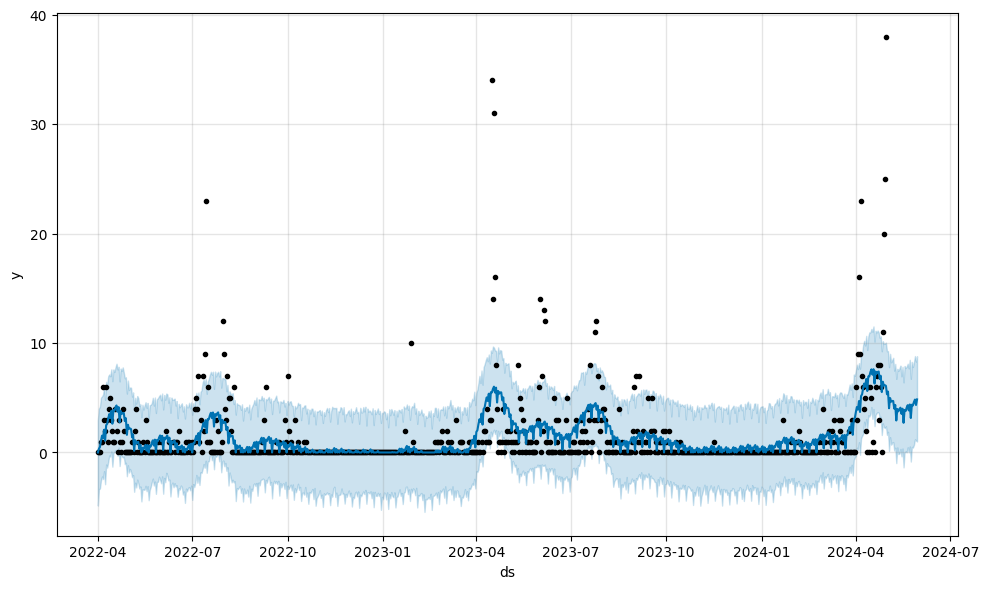

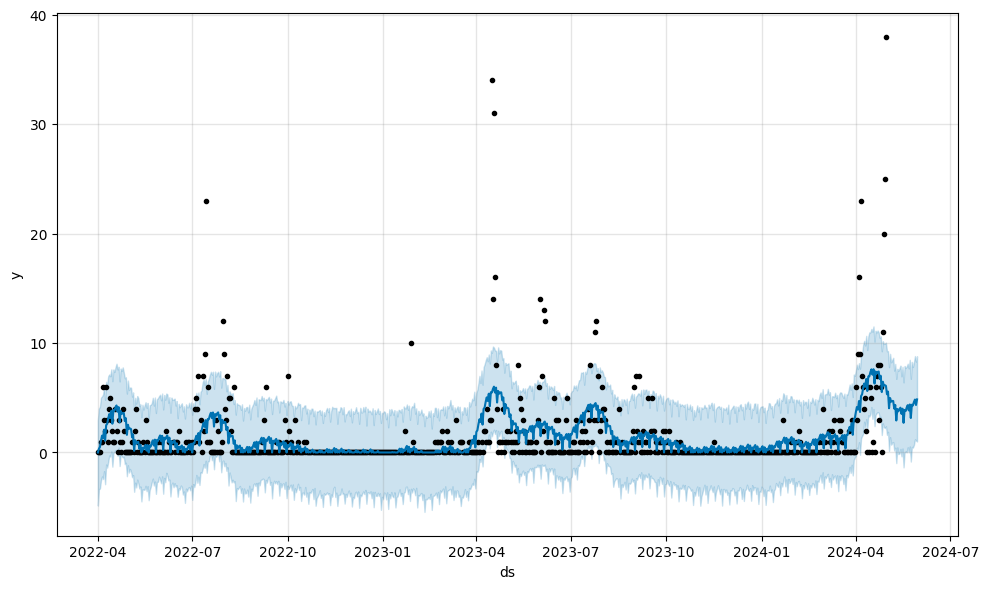

In [8]:
models[3].plot(predictions['17 inch Fan'])

In [9]:
def mean_absolute_error(y_true, y_pred):
    sum = 0
    for i in range(30):
        diff = np.abs(y_pred.iloc[i] - y_true.iloc[i])
        sum += diff
    print(sum/30)
mean_absolute_error(sales_data_matrix['17 inch Fan'].head(30), predictions['17 inch Fan']['yhat'].head(30))    

1.6986140581053724


In [10]:
y_true = sales_data_matrix['17 inch Fan']
y_pred = predictions['17 inch Fan']['yhat'].loc[:760]

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
print(mean_absolute_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred))
print(root_mean_squared_error(y_true, y_pred))

1.35244442331803
8.731780751123274
2.954958671643865


In [51]:
amount_data = amount_data.rename(columns={'Date': 'ds', 'Amount': 'y'})
amount_data

,ds,y
0,2022-04-01,0
1,2022-04-02,239400
2,2022-04-03,274140
3,2022-04-04,177000
4,2022-04-05,106000
...,...,...
756,2024-04-26,0
757,2024-04-27,582650
758,2024-04-28,367700
759,2024-04-29,451000


In [52]:
count = 0
holidays = []
for i in amount_data.index:
    if amount_data['y'][i] == 0:
        holidays.append(amount_data['ds'][i])
        count += 1
print(count)  
print(holidays) 

weekends = pd.DataFrame({
  'holiday': 'weekends',
  'ds': pd.to_datetime(holidays)
})

weekends

83
[Timestamp('2022-04-01 00:00:00'), Timestamp('2022-05-13 00:00:00'), Timestamp('2022-05-20 00:00:00'), Timestamp('2022-05-27 00:00:00'), Timestamp('2022-06-03 00:00:00'), Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-17 00:00:00'), Timestamp('2022-07-22 00:00:00'), Timestamp('2022-07-29 00:00:00'), Timestamp('2022-08-12 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-09-02 00:00:00'), Timestamp('2022-09-09 00:00:00'), Timestamp('2022-09-16 00:00:00'), Timestamp('2022-10-14 00:00:00'), Timestamp('2022-10-21 00:00:00'), Timestamp('2022-10-28 00:00:00'), Timestamp('2022-11-04 00:00:00'), Timestamp('2022-11-11 00:00:00'), Timestamp('2022-11-18 00:00:00'), Timestamp('2022-11-25 00:00:00'), Timestamp('2022-12-02 00:00:00'), Timestamp('2022-12-10 00:00:00'), Timestamp('2022-12-16 00:00:00'), Timestamp('2022-12-23 00:00:00'), Timestamp('2022-12-30 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp(

,holiday,ds
0,weekends,2022-04-01
1,weekends,2022-05-13
2,weekends,2022-05-20
3,weekends,2022-05-27
4,weekends,2022-06-03
...,...,...
78,weekends,2024-03-15
79,weekends,2024-04-12
80,weekends,2024-04-14
81,weekends,2024-04-19


In [53]:
m = Prophet(holidays = weekends, seasonality_mode = 'multiplicative', yearly_seasonality=50)
m.fit(amount_data)

12:52:43 - cmdstanpy - INFO - Chain [1] start processing
12:52:43 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
forecast = m.predict()
amount_prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

amount_prediction

,ds,yhat,yhat_lower,yhat_upper
0,2022-04-01,23253.610086,-101261.343322,155586.340507
1,2022-04-02,120720.847533,-11935.995662,252126.086322
2,2022-04-03,107844.743157,-24705.992786,249344.850787
3,2022-04-04,105226.649217,-30183.824755,229411.361052
4,2022-04-05,122240.401856,-6208.060363,251282.364029
...,...,...,...,...
756,2024-04-26,138258.078854,10092.573855,266234.875447
757,2024-04-27,316346.673219,187850.745662,458708.427749
758,2024-04-28,325970.534264,189073.481341,458423.619486
759,2024-04-29,311597.283025,179975.848825,445593.133764


In [55]:
count = 0
holidays = []
for i in amount_data.index:
    if amount_data['y'][i] == 0:
        amount_prediction.loc[i, 'yhat'] = 0
        count += 1
print(count)  
amount_prediction

83


,ds,yhat,yhat_lower,yhat_upper
0,2022-04-01,0.000000,-101261.343322,155586.340507
1,2022-04-02,120720.847533,-11935.995662,252126.086322
2,2022-04-03,107844.743157,-24705.992786,249344.850787
3,2022-04-04,105226.649217,-30183.824755,229411.361052
4,2022-04-05,122240.401856,-6208.060363,251282.364029
...,...,...,...,...
756,2024-04-26,0.000000,10092.573855,266234.875447
757,2024-04-27,316346.673219,187850.745662,458708.427749
758,2024-04-28,325970.534264,189073.481341,458423.619486
759,2024-04-29,311597.283025,179975.848825,445593.133764


In [62]:
amount_y_true = amount_data['y']
amount_y_pred = amount_prediction['yhat']

print(mean_absolute_error(amount_y_true, amount_y_pred))

64432.67716401985


C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


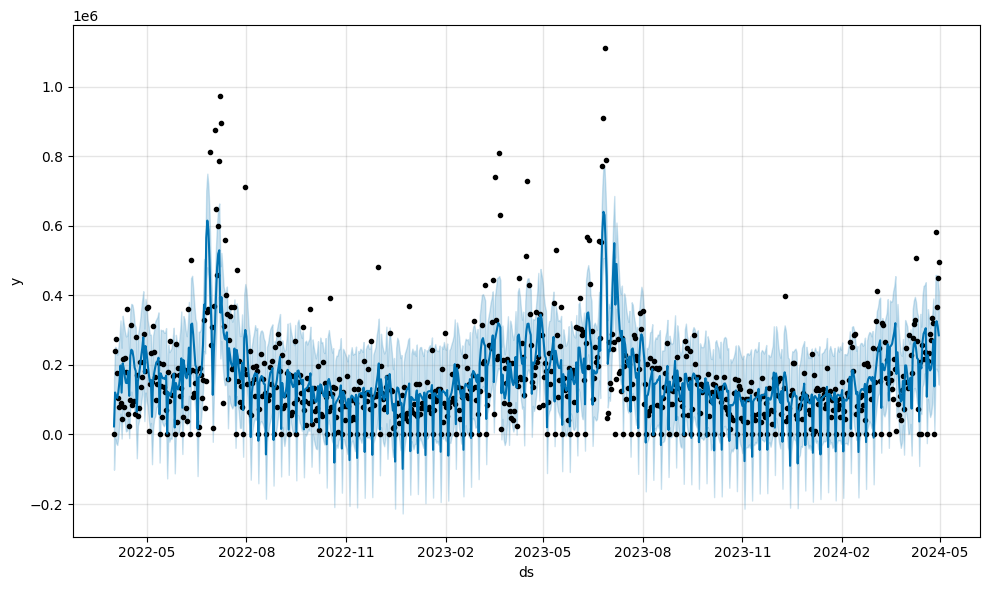

In [57]:
m.plot(forecast)
plt.show()

C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\CP LAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0

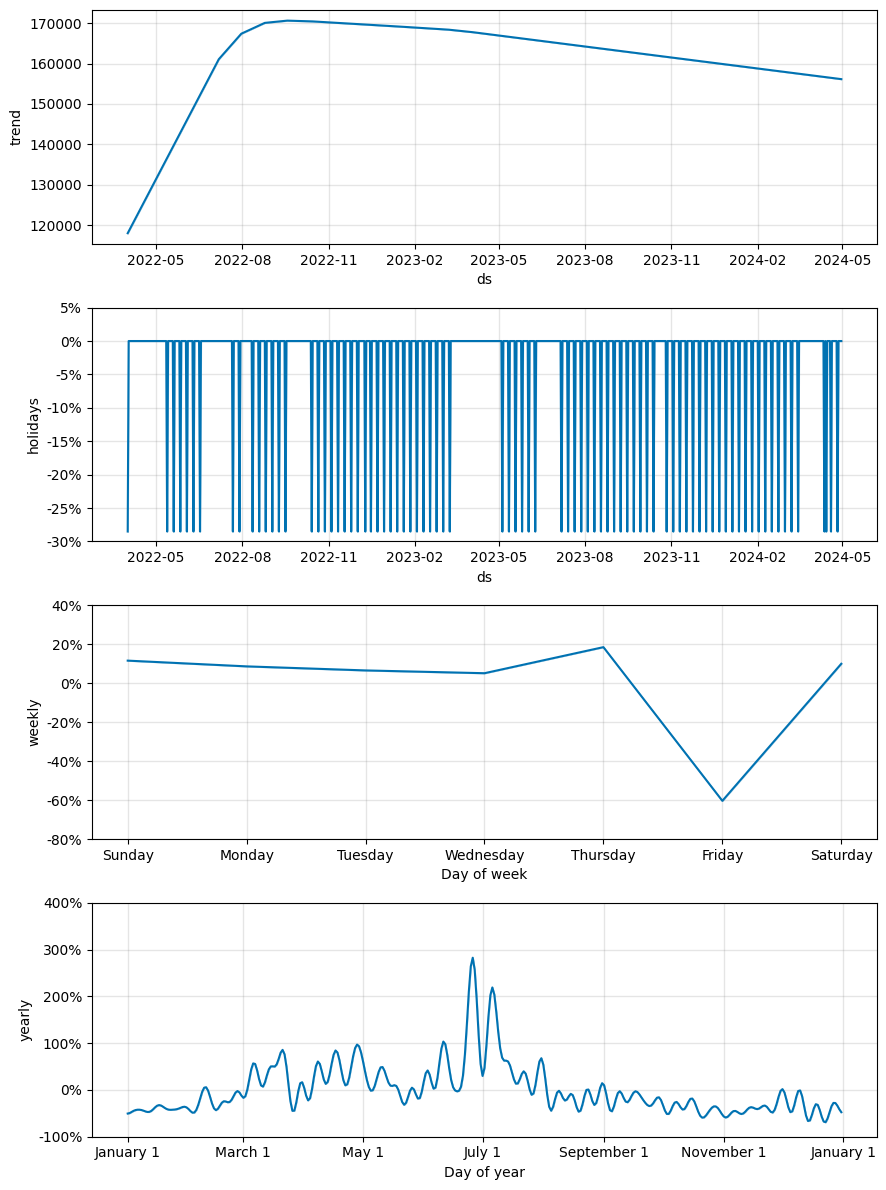

In [58]:
m.plot_components(forecast)
plt.show()